In [5]:
# 1. Impor Library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error

# Mengatur style plot
plt.style.use('fivethirtyeight')



2025-04-30 03:57:24.710102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# 2. Fungsi Bantuan (dari notebook)
def prediction_plot(test, predicted):
    """
    Memvisualisasikan harga saham aktual vs. harga saham prediksi.

    Args:
      test (numpy.ndarray): Array harga saham aktual (set pengujian).
      predicted (numpy.ndarray): Array harga saham yang diprediksi.
    """
    plt.figure(figsize=(12, 6)) # Menyesuaikan ukuran plot
    plt.plot(test, color='red', label='Harga Saham Aktual (Open)')
    plt.plot(predicted, color='blue', label='Harga Saham Prediksi (Open)')
    plt.title('Prediksi Harga Saham AMZN (Open) - Set Pengujian')
    plt.xlabel('Waktu (Hari dalam set pengujian)')
    plt.ylabel('Harga Saham (Open)')
    plt.legend()
    plt.grid(True) # Menambahkan grid
    plt.show()

def rmse_eval(test, predicted):
    """
    Menghitung dan mencetak Root Mean Squared Error (RMSE).

    Args:
      test (numpy.ndarray): Array harga saham aktual.
      predicted (numpy.ndarray): Array harga saham yang diprediksi.
    """
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}') # Format output RMSE



Dataset berhasil dimuat.
Index Date berhasil diatur.

--- Analisis Data Eksploratif (EDA) ---

Statistik deskriptif dataset:
              Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean    299.335310   302.371163   296.037695   299.376231  5.931712e+06
std     280.120547   281.826442   277.927134   279.980161  5.122034e+06
min      26.090000    26.300000    25.760000    26.070000  9.864350e+05
25%      81.175000    82.580000    79.725000    81.090000  3.137037e+06
50%     205.330000   208.000000   202.100000   205.440000  4.724100e+06
75%     375.570000   379.155000   373.000000   375.140000  7.135246e+06
max    1204.880000  1213.410000  1191.150000  1195.830000  1.044046e+08

Beberapa baris pertama dataset:
             Open   High    Low  Close   Volume  Name
Date                                                 
2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
2006-01-04  47.48  47.73  46.69 

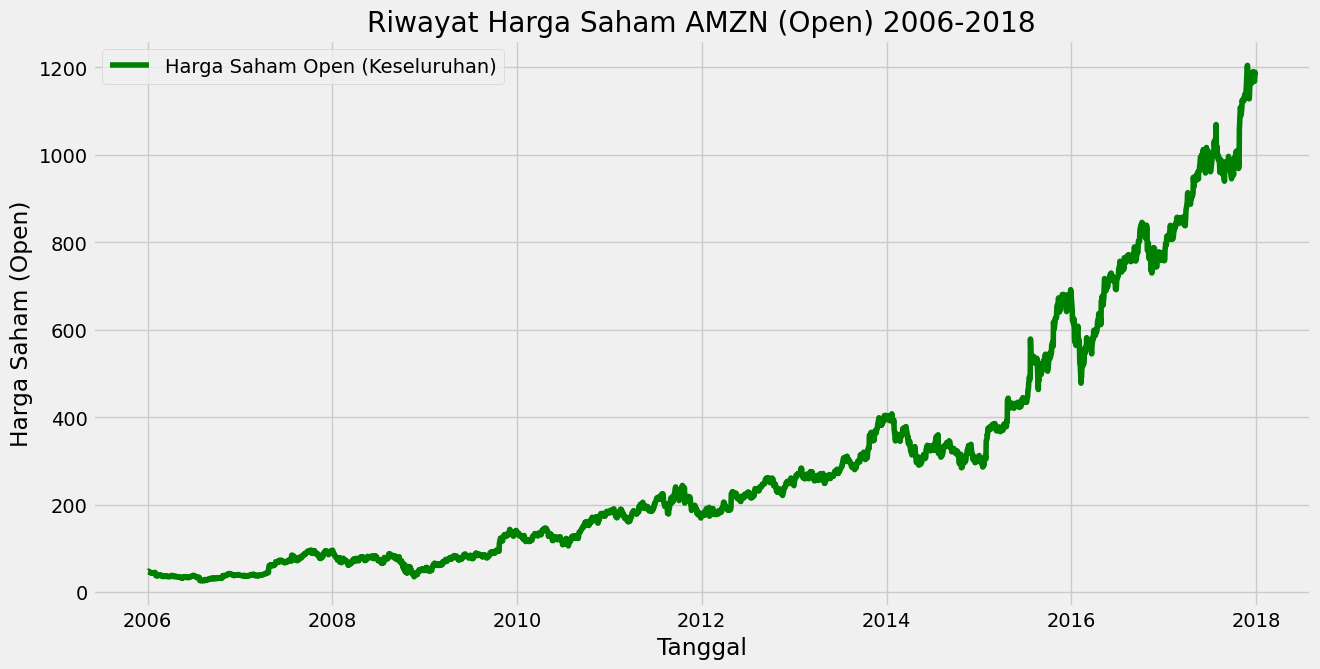

--- Akhir EDA ---


In [7]:
# 3. Muat Dataset Baru
file_path = 'AMZN_2006-01-01_to_2018-01-01.csv' # Path ke file CSV baru Anda
try:
    dataset = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    # Mengubah kolom 'Date' menjadi tipe datetime dan menjadikannya index
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset.set_index('Date')
    print("Index Date berhasil diatur.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di {file_path}")
    exit()
except Exception as e:
    print(f"Error saat memuat atau memproses dataset: {e}")
    exit()

# --- EDA Tambahan: Pemeriksaan dan Visualisasi Data Awal ---
print("\n--- Analisis Data Eksploratif (EDA) ---")
# Pemeriksaan data
print("\nStatistik deskriptif dataset:")
print(dataset.describe())

print("\nBeberapa baris pertama dataset:")
print(dataset.head())

# Visualisasi data keseluruhan (Harga Open)
print("\nMemvisualisasikan Riwayat Harga Saham 'Open' Keseluruhan...")
plt.figure(figsize=(14, 7)) # Ukuran plot lebih besar
plt.plot(dataset.index, dataset['Open'], color='green', label='Harga Saham Open (Keseluruhan)') # Menggunakan index Date untuk sumbu X
plt.title('Riwayat Harga Saham AMZN (Open) 2006-2018')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (Open)')
plt.legend()
plt.grid(True)
plt.show()
print("--- Akhir EDA ---")
# ---------------------------------------------------------




In [8]:
# 4. Pemisahan Data & Pemilihan Kolom ('Open')
# Tentukan batas tahun untuk data training dan testing
train_end_year = '2016'
test_start_year = '2017'

# Ambil data 'Open' untuk training dan testing
if 'Open' not in dataset.columns:
    print("Error: Kolom 'Open' tidak ditemukan dalam dataset.")
    exit()

training_set = dataset[:train_end_year][['Open']].values
test_set = dataset[test_start_year:][['Open']].values

print(f"\nUkuran set pelatihan: {len(training_set)} data points")
print(f"Ukuran set pengujian: {len(test_set)} data points")

if len(training_set) == 0 or len(test_set) == 0:
    print("Error: Set pelatihan atau pengujian kosong. Periksa rentang tahun.")
    exit()




Ukuran set pelatihan: 2768 data points
Ukuran set pengujian: 251 data points


In [9]:
# 5. Penskalaan Data Pelatihan
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
print("Penskalaan data pelatihan selesai.")

# 6. Membuat Struktur Data Sekuensial untuk Pelatihan
X_train = []
y_train = []
time_steps = 60
if len(training_set_scaled) <= time_steps:
     print(f"Error: Data pelatihan tidak cukup panjang ({len(training_set_scaled)}) untuk time_steps={time_steps}.")
     exit()

for i in range(time_steps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(f"Bentuk X_train sebelum reshape: {X_train.shape}")
print(f"Bentuk y_train: {y_train.shape}")



Penskalaan data pelatihan selesai.
Bentuk X_train sebelum reshape: (2708, 60)
Bentuk y_train: (2708,)


In [10]:
# 7. Reshape Data Pelatihan untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"Bentuk X_train setelah reshape: {X_train.shape}")

# 8. Bangun Arsitektur Model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))



Bentuk X_train setelah reshape: (2708, 60, 1)


/Library/Python/3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Ringkasan Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)


Memulai training model dengan 100 epochs dan batch_size=32...
Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 0.0315
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0023
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0019
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0019
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0016
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0016
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0015
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0013
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0015
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0012
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0013
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0012
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0012
Epoch 14/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss:

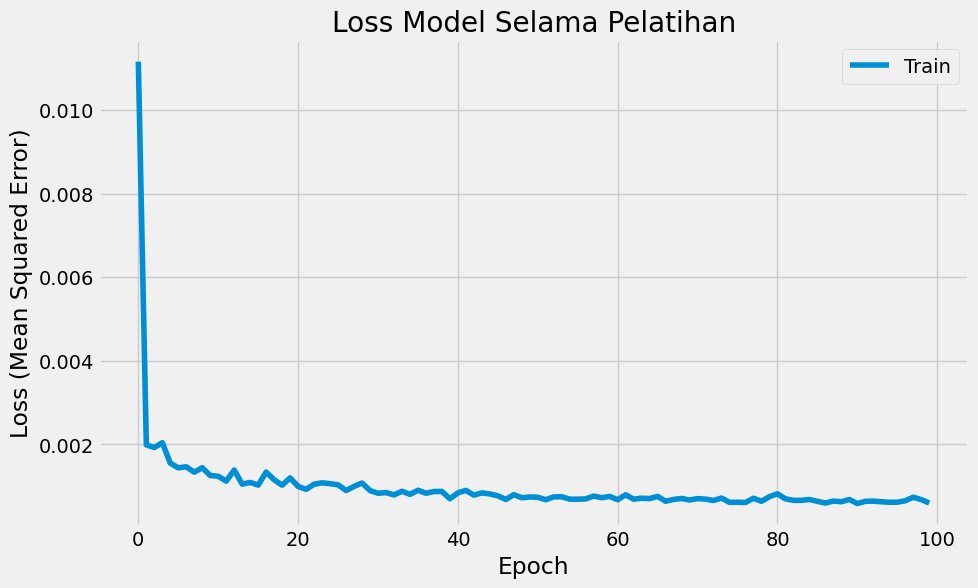

In [11]:
# 9. Kompilasi Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

print("\nRingkasan Model:")
model.summary()

# 10. Latih Model
epochs = 100
batch_size = 32
print(f"\nMemulai training model dengan {epochs} epochs dan batch_size={batch_size}...")
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
print("Training model selesai.")

# Plot loss selama training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Loss Model Selama Pelatihan')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.grid(True)
plt.show()



In [12]:
# 11. Persiapan Data Pengujian
dataset_train_open = dataset[:train_end_year][['Open']]
dataset_test_open = dataset[test_start_year:][['Open']]
dataset_total = pd.concat((dataset_train_open, dataset_test_open), axis=0)

inputs = dataset_total[len(dataset_total) - len(test_set) - time_steps:].values
inputs = inputs.reshape(-1, 1)

try:
    inputs_scaled = sc.transform(inputs)
    print("Penskalaan input data pengujian selesai.")
except Exception as e:
    print(f"Error saat scaling input data pengujian: {e}")
    exit()

X_test = []
if len(inputs_scaled) < time_steps:
     print(f"Error: Data input pengujian tidak cukup panjang ({len(inputs_scaled)}) untuk time_steps={time_steps}.")
     exit()

for i in range(time_steps, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-time_steps:i, 0])

X_test = np.array(X_test)
print(f"Bentuk X_test sebelum reshape: {X_test.shape}")

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(f"Bentuk X_test setelah reshape: {X_test.shape}")



Penskalaan input data pengujian selesai.
Bentuk X_test sebelum reshape: (251, 60)
Bentuk X_test setelah reshape: (251, 60, 1)


In [13]:
# 12. Lakukan Prediksi
print("\nMemulai prediksi pada data test...")
predicted_stock_price_scaled = model.predict(X_test)
print("Prediksi selesai.")

# 13. Kembalikan Hasil Prediksi ke Skala Asli
try:
    predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
    print("Inverse transform prediksi selesai.")
except Exception as e:
    print(f"Error saat inverse transform prediksi: {e}")
    exit()




Memulai prediksi pada data test...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Prediksi selesai.
Inverse transform prediksi selesai.



Memvisualisasikan hasil prediksi...


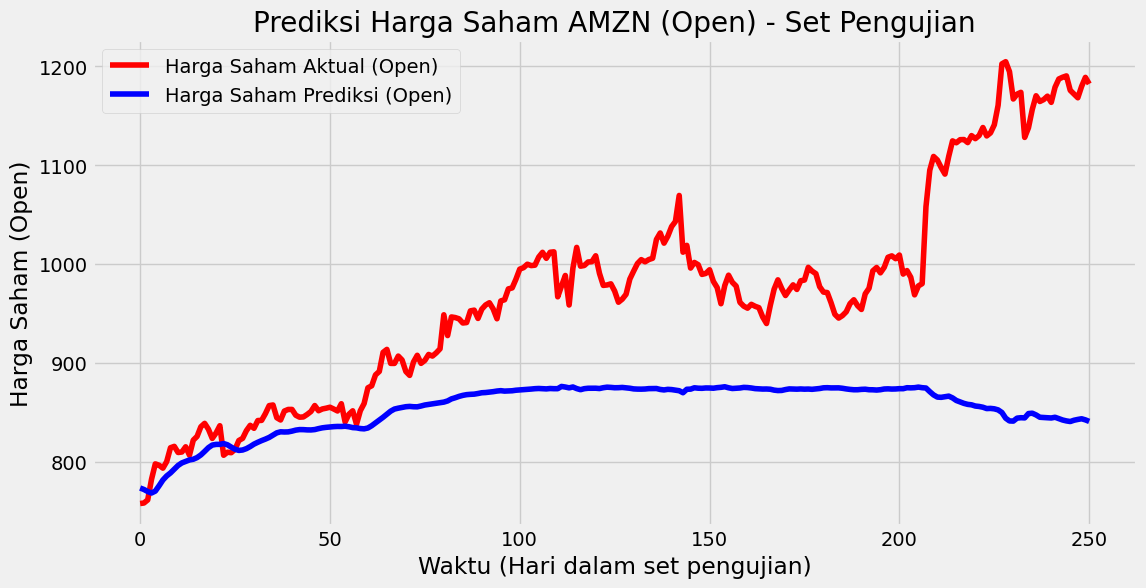


Mengevaluasi model...
Root Mean Squared Error (RMSE): 149.4191

Proses selesai.


In [14]:
# 14. Visualisasi Hasil Prediksi vs Aktual
print("\nMemvisualisasikan hasil prediksi...")
if len(test_set) == len(predicted_stock_price):
    prediction_plot(test_set, predicted_stock_price) # Memanggil fungsi plot prediksi
else:
    print(f"Error: Panjang data aktual ({len(test_set)}) tidak sama dengan panjang prediksi ({len(predicted_stock_price)}). Tidak bisa plot.")
    if len(predicted_stock_price) > len(test_set):
        print("Mencoba memotong prediksi agar sesuai dengan data aktual...")
        predicted_stock_price = predicted_stock_price[:len(test_set)]
        prediction_plot(test_set, predicted_stock_price)

# 15. Evaluasi Model (RMSE)
print("\nMengevaluasi model...")
if len(test_set) == len(predicted_stock_price):
    rmse_eval(test_set, predicted_stock_price) # Memanggil fungsi evaluasi RMSE
else:
    print("Tidak dapat menghitung RMSE karena panjang data aktual dan prediksi berbeda.")

print("\nProses selesai.")